In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from model import Activity, Dictionary, SparseModel, sparsity_loss, dictionary_loss
import torch
import scipy.io
import matplotlib.pyplot as plt
import cv2

In [70]:
mean = [125.3, 123.0, 113.9]
std = [63.0, 62.1, 66.7]

In [120]:
np.mean(std)

63.93333333333334

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [107]:
mat = scipy.io.loadmat('D:\job\moberg\sparse coding\cifar/sparsecodes/filters_8x8x3_128_v1.mat')
dic = torch.from_numpy((mat['weight_vals'].astype(np.float32))).to(device)
dic = dic.permute(3,2,1,0)
dic = dic.float()/dic.max()
dic = torch.reshape(dic, [128, 8*8*3]).T
print(np.shape(dic)) #---> torch.Size([128,3,8,8])

torch.Size([192, 128])


In [117]:
test_img = cv2.imread('D:\job\moberg\sparse coding\cifar/test_imgs/CIFAR_00004.png')

In [121]:
test_img = (test_img-120.7)/63.9

In [122]:
test_img = np.reshape(test_img, [16, -1])

In [143]:
batch_size = 1680
epsilon = 1e-6
num_filters = 128
patches_per_img = 4
alpha = 0.001 #learning rate
sparsity_coef = 0.1 # sparsity coef
beta = .99 #The amount to retain for A and B
img_size = 28
dict_filter_size = 192
activity_epochs = 300
epochs=30
num_layers=1

In [144]:
sparse_activity = Activity(batch_size=batch_size, units=num_filters, alpha=alpha, sparsity_coef=sparsity_coef)
sparse_dictionary = Dictionary(units=num_filters, dict_filter_size=dict_filter_size, beta=beta)
sparse_model = SparseModel(sparse_activity, sparse_dictionary, batch_size=batch_size, activity_epochs=activity_epochs, dict_filter_size=dict_filter_size, data_size=0, num_layers=num_layers)
sparse_model.compile(sparsity_loss, dictionary_loss)

In [145]:
sparse_model.dictionary.w = dic

In [146]:
test_img.min()

-1.3724569640062598

In [147]:
test_img.max()

1.7730829420970267

In [148]:
sparse_model.activity.reset()

In [149]:
sparse_model.activity.w.min()

tensor(-4.7206, device='cuda:0')

In [150]:
sparse_model.dictionary.w.max()

tensor(1., device='cuda:0')

In [151]:
test_reconstruction = sparse_model.forward(torch.from_numpy(test_img ).to(device))

In [152]:
test_reconstruction.min()

tensor(-1.8394, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


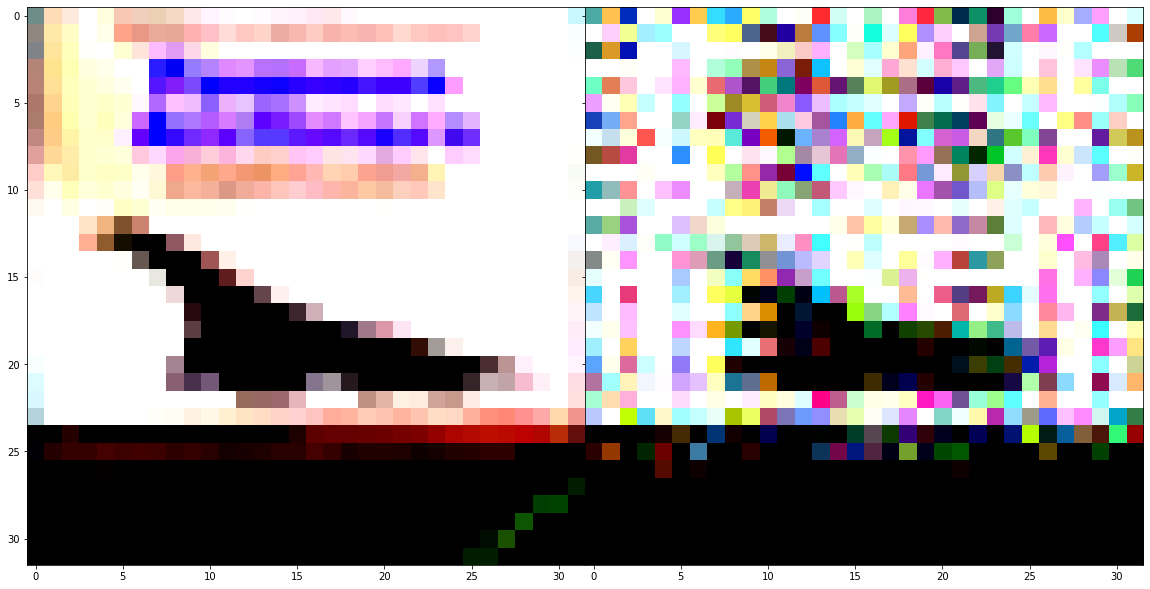

In [153]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
axs[0].imshow(test_img.reshape([32, 32, 3]))
axs[1].imshow(test_reconstruction.reshape([32, 32, 3]).cpu())
plt.show()